In [14]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline
import librosa.display
import IPython.display


In [15]:
os.chdir('/Users/Ashwin/Desktop/UrbanSound8K/audio/fold1')

In [16]:
def load_sound_files(file_paths):
    #print(file_paths)
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

In [17]:
def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(10,30))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()

In [18]:
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(10,30))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

In [19]:
def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(10,30))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        S = np.abs(librosa.stft(f))
        D = librosa.power_to_db(S**2, ref=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

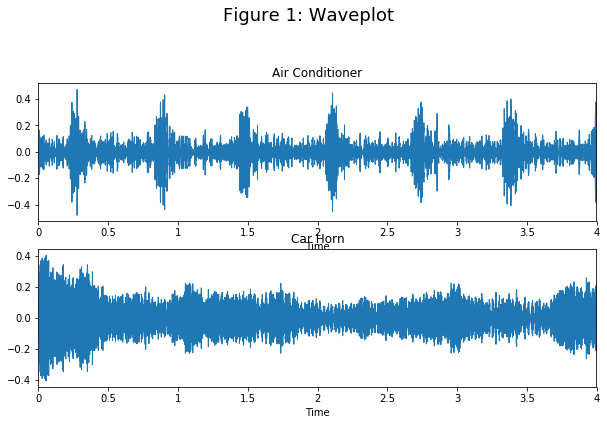

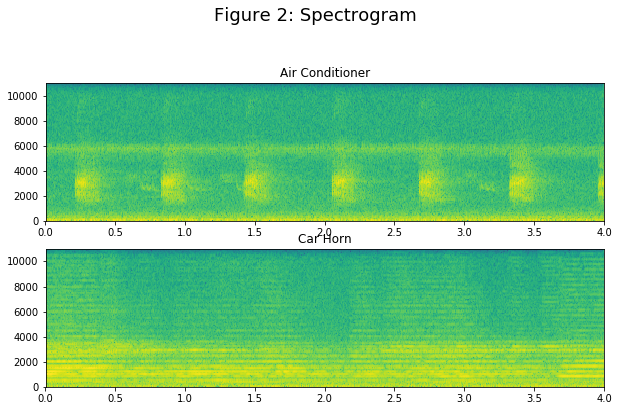

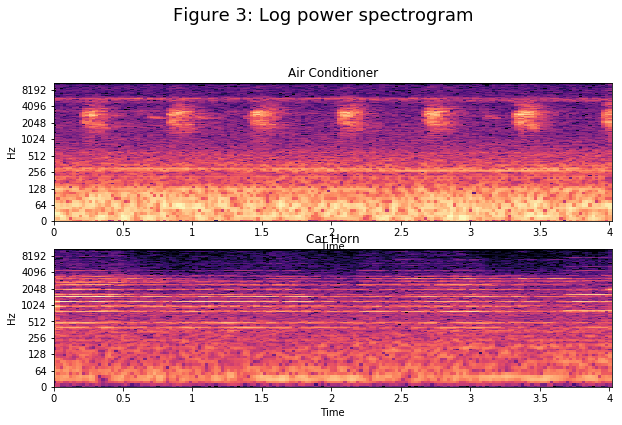

In [20]:
sound_file_paths = ["57320-0-0-7.wav","24074-1-0-3.wav"]

sound_names = ["air conditioner", "car horn"]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)
plot_specgram(sound_names,raw_sounds)
plot_log_power_specgram(sound_names,raw_sounds)

In [21]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)

In [22]:
def extract_logmelspecanddelta(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            label = fn.split('/')[7].split('-')[1]
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.power_to_db(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    log_specgrams_delta = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(log_specgrams_delta)):
        log_specgrams_delta[i, :, :, 1] = librosa.feature.delta(log_specgrams_delta[i, :, :, 0])
    
    return np.array(log_specgrams_delta), np.array(labels,dtype = np.int)

In [23]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [25]:
parent_dir = '/Users/Ashwin/Desktop/UrbanSound8K/audio/'
train_sub_dirs= ['fold1']
train_data,train_labels = extract_logmelspecanddelta(parent_dir,train_sub_dirs)
train_labels = one_hot_encode(train_labels)

test_sub_dirs= ['fold3']
test_data,test_labels = extract_logmelspecanddelta(parent_dir,test_sub_dirs)
test_labels = one_hot_encode(test_labels)

In [28]:
train_labels.shape

(5446, 10)

In [29]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


In [30]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=train_data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


In [31]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 41, 64)        1216      
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 20, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 20, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 18, 32)        18464     
_________________________________________________________________
activation_2 (Activation)    (None, 28, 18, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 9, 32)         0         
__________

In [33]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

In [34]:
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
train_data /= 255
test_data /= 255

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

In [38]:
history = model.fit(train_data, train_labels,
                    batch_size=64,
                    epochs=5,
                    verbose=1,
                    validation_data=(test_data, test_labels))

Train on 5446 samples, validate on 5852 samples
Epoch 1/5
5446/5446 [==============================] - 48s 9ms/step - loss: 2.1341 - acc: 0.1963 - val_loss: 2.1479 - val_acc: 0.2478
Epoch 2/5
5446/5446 [==============================] - 46s 9ms/step - loss: 1.9195 - acc: 0.2853 - val_loss: 2.2088 - val_acc: 0.1953
Epoch 3/5
5446/5446 [==============================] - 47s 9ms/step - loss: 1.8102 - acc: 0.3226 - val_loss: 2.2244 - val_acc: 0.1746
Epoch 4/5
5446/5446 [==============================] - 56s 10ms/step - loss: 1.7403 - acc: 0.3557 - val_loss: 2.2468 - val_acc: 0.2274
Epoch 5/5
5446/5446 [==============================] - 46s 8ms/step - loss: 1.6666 - acc: 0.3931 - val_loss: 2.1623 - val_acc: 0.2095
